# 3 layer Conv Encoder, LSTM Decoder. 60 day input, 7 day forecast

In [1]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from keras.layers import Input
from keras.models import Sequential, load_model, Model
from sklearn.metrics import mean_squared_error
from keras import regularizers

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

Using TensorFlow backend.


In [2]:
save_dir = 'models/lstm9'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
data = df.values

In [3]:
num_input = 60
num_out = 7
train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = utils.prepare_data(data, num_input, num_preds=num_out)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
train_y_acc = train_y_acc.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y_acc = dev_y_acc.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y_acc = test_y_acc.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)
print("train_y_acc shape", train_y_acc.shape)
print("dev_y_acc shape", dev_y_acc.shape)
print("test_y_acc shape", test_y_acc.shape)

train_X shape (613, 60, 25)
train_y shape (613, 7, 1)
dev_X shape (77, 60, 25)
dev_y shape (77, 7, 1)
test_X shape (77, 60, 25)
test_y shape (77, 7, 1)
train_y_acc shape (613, 7, 1)
dev_y_acc shape (77, 7, 1)
test_y_acc shape (77, 7, 1)


In [4]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.001
decay = 1e-6
dropout_rate = 0.5
epochs = 200
batch_size = 32

Input_X = Input(shape=input_shape)
X = Conv1D(filters=64, kernel_size=3, activation='linear', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.005))(Input_X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(dropout_rate)(X)

X = Conv1D(filters=96, kernel_size=3, activation='linear', kernel_regularizer=regularizers.l2(0.01))(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(dropout_rate)(X)
X = MaxPooling1D(pool_size=2)(X)

X = Conv1D(filters=128, kernel_size=3, activation='linear', kernel_regularizer=regularizers.l2(0.01))(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(dropout_rate)(X)

X = LSTM(200, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01))(X)
X = RepeatVector(num_out)(X)

X = LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(X)

X_mse = TimeDistributed(Dense(100, activation='relu'))(X)
out_mse = TimeDistributed(Dense(1))(X_mse)

X_binary = TimeDistributed(Dense(100, activation='relu'))(X)
out_binary = TimeDistributed(Dense(1, activation='sigmoid'))(X_binary)

model = Model(inputs=[Input_X], outputs=[out_mse, out_binary])
# model = Sequential()
# model.add(Conv1D(filters=64, kernel_size=3, activation='linear', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.005)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(dropout_rate))

# model.add(Conv1D(filters=96, kernel_size=3, activation='linear', kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(dropout_rate))
# model.add(MaxPooling1D(pool_size=2))

# model.add(Conv1D(filters=128, kernel_size=3, activation='linear', kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(dropout_rate))

# model.add(LSTM(200, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)))
# model.add(RepeatVector(num_out))

# model.add(LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))
# model.add(TimeDistributed(Dense(100, activation='relu')))
# model.add(TimeDistributed(Dense(1, activation='sigmoid')))

opt = Adam(lr=lr, decay=decay)
model.compile(loss=["mse", "binary_crossentropy"], optimizer=opt)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60, 25)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 58, 64)       4864        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 58, 64)       256         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activat

In [5]:
history = model_funcs.train(
    model,
    train_X,
    [train_y, train_y_acc],
    (dev_X, [dev_y, dev_y_acc]),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 200 epochs, 32 batch size
Instructions for updating:
Use tf.cast instead.
Train on 613 samples, validate on 77 samples
Epoch 1/200
613/613 [==============================] - 5s 9ms/step - loss: 6.3583 - time_distributed_2_loss: 0.0375 - time_distributed_4_loss: 0.6904 - val_loss: 4.4507 - val_time_distributed_2_loss: 0.0039 - val_time_distributed_4_loss: 0.6989
Epoch 2/200
613/613 [==============================] - 2s 3ms/step - loss: 3.3865 - time_distributed_2_loss: 0.0126 - time_distributed_4_loss: 0.6879 - val_loss: 2.3925 - val_time_distributed_2_loss: 0.0036 - val_time_distributed_4_loss: 0.7073
Epoch 3/200
613/613 [==============================] - 2s 3ms/step - loss: 1.8733 - time_distributed_2_loss: 0.0088 - time_distributed_4_loss: 0.6859 - val_loss: 1.4334 - val_time_distributed_2_loss: 0.0080 - val_time_distributed_4_loss: 0.7030
Epoch 4/200
613/613 [==============================] - 2s 3ms/step - loss: 1.1989 - time_distributed_2_loss: 0.00

Epoch 33/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6884 - time_distributed_2_loss: 0.0045 - time_distributed_4_loss: 0.6585 - val_loss: 0.7366 - val_time_distributed_2_loss: 0.0063 - val_time_distributed_4_loss: 0.7044
Epoch 34/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6914 - time_distributed_2_loss: 0.0054 - time_distributed_4_loss: 0.6579 - val_loss: 0.7392 - val_time_distributed_2_loss: 0.0120 - val_time_distributed_4_loss: 0.6980
Epoch 35/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6926 - time_distributed_2_loss: 0.0058 - time_distributed_4_loss: 0.6564 - val_loss: 0.7627 - val_time_distributed_2_loss: 0.0145 - val_time_distributed_4_loss: 0.7175
Epoch 36/200
613/613 [==============================] - 2s 3ms/step - loss: 0.7011 - time_distributed_2_loss: 0.0059 - time_distributed_4_loss: 0.6633 - val_loss: 0.7369 - val_time_distributed_2_loss: 0.0098 - val_time_distributed_4_loss: 0.6947
Epoch 37/200
613

613/613 [==============================] - 2s 3ms/step - loss: 0.6753 - time_distributed_2_loss: 0.0044 - time_distributed_4_loss: 0.6254 - val_loss: 0.7560 - val_time_distributed_2_loss: 0.0048 - val_time_distributed_4_loss: 0.7062
Epoch 100/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6666 - time_distributed_2_loss: 0.0039 - time_distributed_4_loss: 0.6183 - val_loss: 0.8190 - val_time_distributed_2_loss: 0.0373 - val_time_distributed_4_loss: 0.7391
Epoch 101/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6655 - time_distributed_2_loss: 0.0043 - time_distributed_4_loss: 0.6179 - val_loss: 0.7410 - val_time_distributed_2_loss: 0.0062 - val_time_distributed_4_loss: 0.6913
Epoch 102/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6736 - time_distributed_2_loss: 0.0037 - time_distributed_4_loss: 0.6219 - val_loss: 0.7459 - val_time_distributed_2_loss: 0.0043 - val_time_distributed_4_loss: 0.6919
Epoch 103/200
613/613 [===

613/613 [==============================] - 2s 3ms/step - loss: 0.7006 - time_distributed_2_loss: 0.0058 - time_distributed_4_loss: 0.5966 - val_loss: 0.9816 - val_time_distributed_2_loss: 0.0692 - val_time_distributed_4_loss: 0.8093
Epoch 166/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6917 - time_distributed_2_loss: 0.0051 - time_distributed_4_loss: 0.5866 - val_loss: 0.9523 - val_time_distributed_2_loss: 0.0279 - val_time_distributed_4_loss: 0.8288
Epoch 167/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6926 - time_distributed_2_loss: 0.0036 - time_distributed_4_loss: 0.5925 - val_loss: 0.8177 - val_time_distributed_2_loss: 0.0056 - val_time_distributed_4_loss: 0.7182
Epoch 168/200
613/613 [==============================] - 2s 3ms/step - loss: 0.6709 - time_distributed_2_loss: 0.0031 - time_distributed_4_loss: 0.5766 - val_loss: 0.8467 - val_time_distributed_2_loss: 0.0122 - val_time_distributed_4_loss: 0.7476
Epoch 169/200
613/613 [===

In [10]:
predicted_train = model.predict(train_X)
predicted_train_mse = predicted_train[0]
predicted_train_binary = predicted_train[1]
print(predicted_train_mse.shape, predicted_train_binary.shape)

(613, 7, 1) (613, 7, 1)


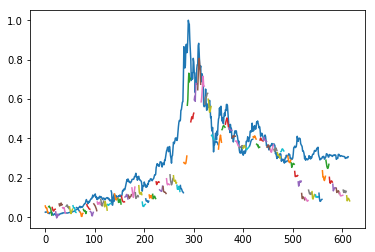

In [29]:
predicted_train_mse, predicted_train_binary = model.predict(train_X)
predicted_train_mse = predicted_train_mse.squeeze()
predicted_train_binary = predicted_train_binary.squeeze()
predicted_train_mse = predicted_train_mse[::num_out]
predicted_train_binary = predicted_train_binary[::num_out]
true_train = train_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_train_mse.tolist(), true_train, num_out)

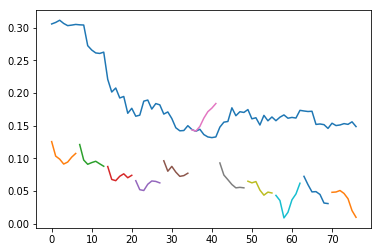

In [30]:
predicted_dev_mse, predicted_dev_binary = model.predict(dev_X)
predicted_dev_mse = predicted_dev_mse.squeeze()
predicted_dev_binary = predicted_dev_binary.squeeze()
predicted_dev_mse = predicted_dev_mse[::num_out]
predicted_dev_binary = predicted_dev_binary[::num_out]
true_dev = dev_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_dev_mse.tolist(), true_dev, num_out)

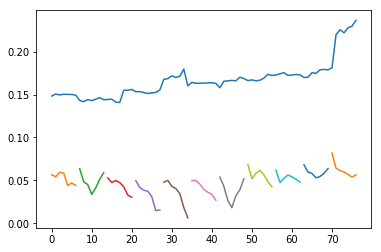

In [31]:
predicted_test_mse, predicted_test_binary = model.predict(test_X)
predicted_test_mse = predicted_test_mse.squeeze()
predicted_test_binary = predicted_test_binary.squeeze()
predicted_test_mse = predicted_test_mse[::num_out]
predicted_test_binary = predicted_test_binary[::num_out]
true_test = test_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_test_mse.tolist(), true_test, num_out)

In [27]:
print("MSE Train:", mean_squared_error(predicted_train_mse.reshape(-1,1)[:len(true_train)], true_train))
print("MSE Dev:", mean_squared_error(predicted_dev_mse.reshape(-1,1)[:len(true_dev)], true_dev))
print("MSE Test:", mean_squared_error(predicted_test_mse.reshape(-1,1)[:len(true_test)], true_test))

MSE Train: 0.01795641885587237
MSE Dev: 0.015770539621745135
MSE Test: 0.014647530374287492


In [28]:
print("Acc Train:", utils.direction_accuracy(predicted_train_mse.reshape(-1,1)[:len(true_train)], true_train))
print("Acc Dev:", utils.direction_accuracy(predicted_dev_mse.reshape(-1,1)[:len(true_dev)], true_dev))
print("Acc Test:", utils.direction_accuracy(predicted_test_mse.reshape(-1,1)[:len(true_test)], true_test))

Acc Train: 0.5473856209150327
Acc Dev: 0.5
Acc Test: 0.39473684210526316


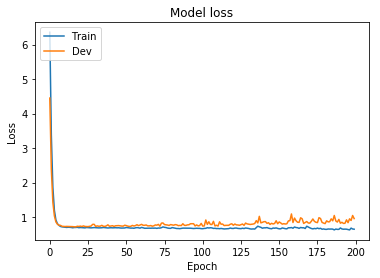

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()

(613, 1)
(613, 1)
(87,)
0.11681119586012371


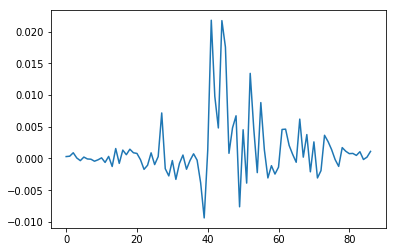

In [32]:
print(true_train.shape)
scores, scores_normalized = utils.get_scores(true_train, predicted_train_binary.reshape(-1,1)[:true_train.shape[0]], num_out)
print(np.sum(scores))
plt.plot(scores)

0.01261833736069701


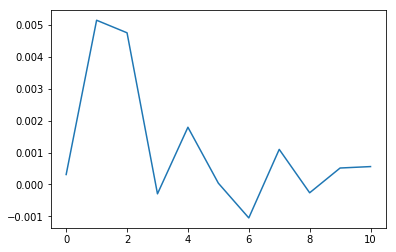

In [37]:
scores, scores_normalized = utils.get_scores(true_dev, predicted_dev_binary.reshape(-1,1), num_out)
print(np.sum(scores))
plt.plot(scores)

(77, 1)
(11,)
-0.005663167726133026


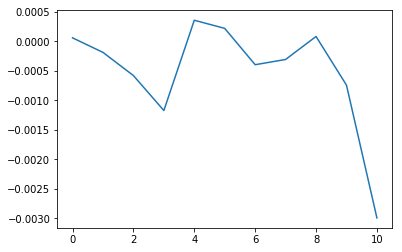

In [36]:
scores, scores_normalized = utils.get_scores(true_test, predicted_test_binary.reshape(-1,1), num_out)
print(np.sum(scores))
plt.plot(scores)